In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib.gridspec import GridSpec

from tools import compute_marginals, compute_means, monitor_progress, pearson_residuals, remove_rare_genes
from nb_regression_R import extract_errors, extract_warnings, r_glmPoisson_MLtheta, r_MLtheta
from scipy.stats import gaussian_kde

### Load preprocessed PBMC data

In [2]:
with open('datasets/33k_pbmc/preprocessed.pickle','rb') as f:
    pmbc = pickle.load(f)
counts_orig = pmbc['counts'].toarray()

/tmp/ipykernel_1001/1863796422.py:2: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  pmbc = pickle.load(f)
tcmalloc: large alloc 4457480192 bytes == 0x22076000 @ 


In [3]:
ns_orig,ps_orig = compute_marginals(counts_orig)
means_orig,mean_min_orig,mean_max_orig,mean_range_orig = compute_means(counts_orig)

### Simulate control data with $\theta = 10$

In [4]:
theta_nbsim = 10

In [5]:
%%time
np.random.seed(42)
mu_nbsim = ns_orig[:, np.newaxis] @ ps_orig[np.newaxis]  
p_nbsim = theta_nbsim / (theta_nbsim + mu_nbsim)
counts_nbsim_raw = np.random.negative_binomial(theta_nbsim, p_nbsim)

tcmalloc: large alloc 4457480192 bytes == 0x12bb88000 @ 
tcmalloc: large alloc 4457480192 bytes == 0x235ea2000 @ 
tcmalloc: large alloc 4457480192 bytes == 0x33f99e000 @ 
tcmalloc: large alloc 4457480192 bytes == 0x235ea2000 @ 
tcmalloc: large alloc 4457480192 bytes == 0x449c9a000 @ 


CPU times: user 49.6 s, sys: 3.98 s, total: 53.6 s
Wall time: 53.6 s


In [6]:
counts_nbsim,genes_nbsim = remove_rare_genes(counts_nbsim_raw,pmbc['genes'], minimum_detected_cells_per_gene = 5)
ns_nbsim,ps_nbsim = compute_marginals(counts_nbsim)
means_nbsim,mean_min_nbsim,mean_max_nbsim,mean_range_nbsim = compute_means(counts_nbsim)

tcmalloc: large alloc 4456685568 bytes == 0x235ea2000 @ 
tcmalloc: large alloc 4367319040 bytes == 0x574ade000 @ 


Of 16806 total genes, returning 16469 genes that are detected in 5 or more cells.
Output shape: (33148, 16469)


### Fit NB regression models

In [7]:
def fit_overspecified_model(counts,depths,name,thetaML_max_iter=10):
    '''for all genes, fit NB regression as Hafemeister&Satija (2019), saving results to file'''
    
    n_genes = counts.shape[1]
    log10_depths = np.log10(depths)    

    
    beta0s = np.zeros((n_genes)) * np.nan
    beta1s = np.zeros((n_genes)) * np.nan
    thetas = np.zeros((n_genes)) * np.nan
    warning_msgs_R = n_genes * [['"fitting error"']]
    errors = n_genes * [None]
    
    for gene_id in range(n_genes):
        
        try:         
            beta0,beta1,theta, warning_msg_R = r_glmPoisson_MLtheta(x=log10_depths,y=counts[:,gene_id],thetaML_max_iter=thetaML_max_iter)
            beta0s[gene_id] = beta0
            beta1s[gene_id] = beta1
            thetas[gene_id] = theta            
            warning_msgs_R[gene_id] = warning_msg_R

        except Exception as error:

            errors[gene_id] = dict(gene_id=gene_id,error=error)
         
        monitor_progress(gene_id,n_genes)

    res = dict(beta0s=beta0s,
               beta1s=beta1s,
               thetas=thetas,
               warning_msgs=extract_warnings(warning_msgs_R),
               errors=extract_errors(errors))

    np.save('fit_results/fit_overspecified_maxIterTheta%u_%s' % (thetaML_max_iter,name),res)

In [8]:
def fit_offsetmodel_w_statsmodel(counts,depths,name):
    '''use statsmodel to fit offsetmodel (Eq. 3) and obtain beta0 (intercept) estimates, saving results to file'''
    n_cells = counts.shape[0]
    n_genes = counts.shape[1]    
    
    ##np.ones: will fit intercept beta0
    X = np.ones((n_cells,1))
    ##log(depths): will be used as offsets
    logdepths = np.log(depths)

    beta0 = np.zeros(n_genes) * np.nan
    for gene_id in range(n_genes):        
        offsetmodel = sm.Poisson(counts[:,gene_id], X, offset = logdepths)
        result = offsetmodel.fit(disp=0)
        beta0[gene_id] = result.params
        
        monitor_progress(gene_id,n_genes)


    res = dict(beta0=beta0)
    np.save('fit_results/fit_offsetmodel_w_statsmodel_%s' % (name),res)

In [9]:
#2h20min
fit_overspecified_model(counts_orig,ns_orig,name='pmbc_hafemeister_satija_reproduction')
#2h30min
fit_overspecified_model(counts_nbsim,ns_nbsim,name='pmbc_simulation_theta%s' % (theta_nbsim))
#4h50min
fit_overspecified_model(counts_nbsim,ns_nbsim,name='pmbc_simulation_theta%s' % (theta_nbsim),thetaML_max_iter=100)

In [10]:
#40min
fit_offsetmodel_w_statsmodel(counts_orig,ns_orig,name='pmbc')

#### Load and process fit results

In [9]:
def fix_diverged_thetas(fit,clipping_threshold,log10jittersize,verbose):
    '''Sets diverged theta estimates to a large value and adds jitter'''
    
    thetas = fit['thetas']
    errors =np.array(fit['errors'])

    thetas_large_idx = thetas > clipping_threshold
    n_thetas_large = np.sum(thetas_large_idx)
    thetas[thetas_large_idx] = 10**(np.log10(clipping_threshold) + (np.random.random_sample(size=(n_thetas_large))*log10jittersize))

    inf_errortypes = ['Error in while ((it <- it + 1) < limit && abs(del) > eps) { : \n  missing value where TRUE/FALSE needed\nCalls: <Anonymous> -> <Anonymous> -> theta.ml\n',
                      'Error in while ((it <- it + 1) < limit && abs(del) > eps) { : \n  missing value where TRUE/FALSE needed\nCalls: <Anonymous> ... <Anonymous> -> withWarnings -> withCallingHandlers -> theta.ml\n',
                      'Error in if (t0 < 0) { : missing value where TRUE/FALSE needed\nCalls: <Anonymous> -> <Anonymous> -> theta.ml\n',
                      'Error in if (t0 < 0) { : missing value where TRUE/FALSE needed\nCalls: <Anonymous> ... <Anonymous> -> withWarnings -> withCallingHandlers -> theta.ml\n']    
    
    inf_errors_idx = np.isin(errors,inf_errortypes)
    n_inf_errors = np.sum(inf_errors_idx)
    thetas[inf_errors_idx] = 10**(np.log10(clipping_threshold) + (np.random.random_sample(size=(n_inf_errors))*log10jittersize))
    
    if verbose:
        print('Clipping %u / %u theta estimates to %u plus noise (because of %u inf divergence errors and %u superlarge estimates).\n %u nans left afterwards.' % (n_inf_errors+n_thetas_large,len(thetas),clipping_threshold,n_inf_errors,n_thetas_large,sum(np.isnan(thetas))))
    
    return thetas

In [10]:
#load all fits
fitfile_orig = 'fit_results/fit_overspecified_maxIterTheta10_pmbc_hafemeister_satija_reproduction.npy'
fitfile_offset_orig = 'fit_results/fit_offsetmodel_w_statsmodel_pmbc.npy'
fitfile_nbsim_iter10 = 'fit_results/fit_overspecified_maxIterTheta10_pmbc_simulation_theta%s.npy' % (theta_nbsim)
fitfile_nbsim_iter100 = 'fit_results/fit_overspecified_maxIterTheta100_pmbc_simulation_theta%s.npy' % (theta_nbsim)

fit_orig = np.load(fitfile_orig,allow_pickle=True).item()
fit_offset_orig =  np.load(fitfile_offset_orig,allow_pickle=True).item()
fit_nbsim_iter10 =  np.load(fitfile_nbsim_iter10,allow_pickle=True).item()
fit_nbsim_iter100 =  np.load(fitfile_nbsim_iter100,allow_pickle=True).item()

#unpack for panel a,b,c
beta0_orig = fit_orig['beta0s']
beta1_orig = fit_orig['beta1s']
theta_orig = fit_orig['thetas']

#unpack for panel e
beta0_offset_orig = fit_offset_orig['beta0']

#unpack for panel f
theta_nbsim_iter10 = fit_nbsim_iter10['thetas']

#unpack and apply clipping function for panel g
fit_dict = dict(errors=fit_nbsim_iter100['errors'])
fit_dict['thetas']=fit_nbsim_iter100['thetas']
theta_nbsim_iter100_clipped = fix_diverged_thetas(fit_dict,clipping_threshold = 10**6,log10jittersize=0.5,verbose=True)

Clipping 8384 / 16469 theta estimates to 1000000 plus noise (because of 6670 inf divergence errors and 1714 superlarge estimates).
 0 nans left afterwards.


### Compute correlation between slope and intercept for overspecified model

In [11]:
np.corrcoef(beta0_orig,beta1_orig)

array([[ 1.        , -0.91278422],
       [-0.91278422,  1.        ]])

### Compute residuals analytically and mark genes H&S identified as variable

In [12]:
%%time
residual_theta = 100
residuals_orig = pearson_residuals(counts_orig,residual_theta)
residual_var_orig = np.var(residuals_orig,axis=0)

tcmalloc: large alloc 4457480192 bytes == 0x235ea2000 @ 
tcmalloc: large alloc 4457480192 bytes == 0x6797de000 @ 
tcmalloc: large alloc 4457480192 bytes == 0x783ada000 @ 
tcmalloc: large alloc 4457480192 bytes == 0x88d5d6000 @ 
tcmalloc: large alloc 4457480192 bytes == 0x235ea2000 @ 


CPU times: user 11.4 s, sys: 3.91 s, total: 15.3 s
Wall time: 15.3 s


In [13]:
variable_genes_orig = ['TUBB1','CLU','PTGDS','GNG11','SDPR','PF4','PPBP','HIST1H2AC','MZB1','IGJ','IGLL5','GZMB','GNLY','S100A8','NKG7','S100A9','CCL5','LYZ','FTL','FTH1']
variable_genes_orig_idx = np.isin(pmbc['genes'],variable_genes_orig)

## Figure 1

In [14]:
dotsize=3
#for broken lines
linewidth_broken = 2
color_broken = 'tab:red'
#axis limits
xlim_satija = [1e-4,1e2]
ylim_satija_theta = [10**-7.5,10**1.5]
ylim_satija_beta0 = [-60,20]
title_fontsize = 22
title_fontweight = "bold"
title_position = (-0.2,1)
title_location = 'center'
title_y_padding = -10
markerfirst = True

alpha=0.05

In [15]:
def make_panel(x,
               y,
               ax,
               letter='',
               title='',
               color_kde=True,
               xlim=xlim_satija,
               ylim=None,
               xlabel='mean expression',
               ylabel='',
               xscale='log',
               yscale='log',):
    
    ax.text(*title_position,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    if color_kde:
        xtrans = np.log10(x) if xscale == 'log' else x
        ytrans = np.log10(y) if yscale == 'log' else y
        data = np.vstack((xtrans,ytrans))
        kde = gaussian_kde(data)
        logdensity = kde.logpdf(data)
        points = ax.scatter(x, y, s=dotsize, c=logdensity,  rasterized=True)

    else:
        ax.scatter(x, y, s=dotsize,  rasterized=True)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
        
    ax.set_title(title)
    
def add_line(x,y,ax):
    ax.plot(x,y, '--',c=color_broken, linewidth=linewidth_broken)
    
def fix_ticks(ax):
    ax.set_yticks(ax.get_yticks()[1:-1])

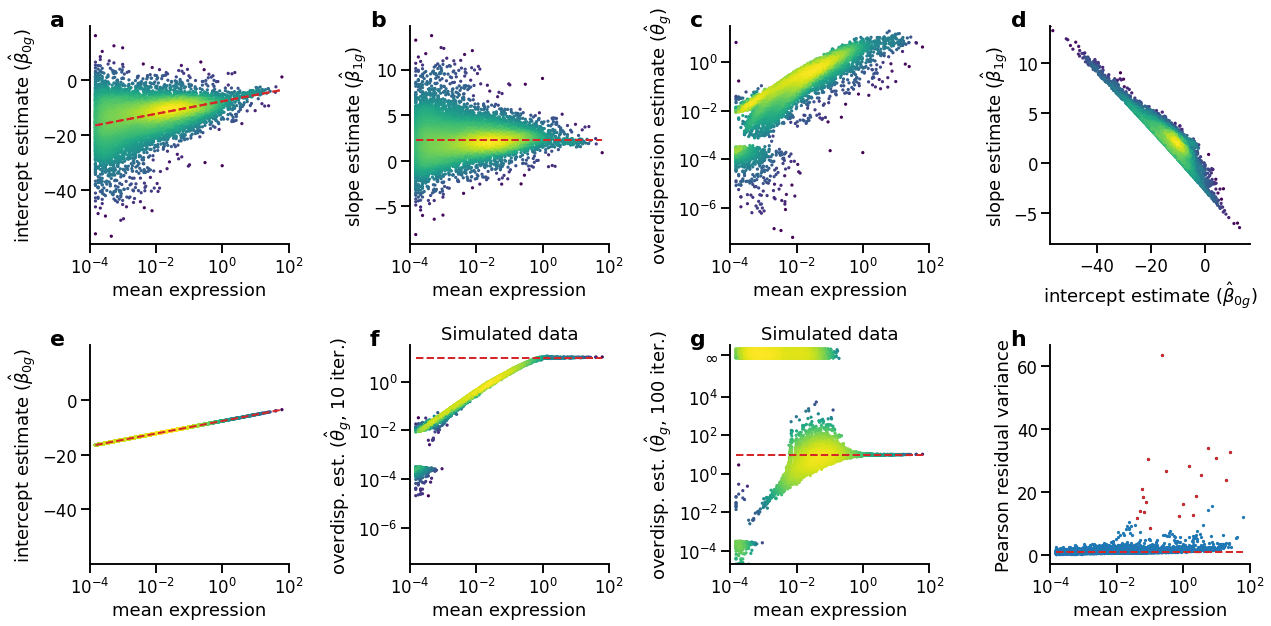

In [16]:
with sns.plotting_context("talk"):


    fig = plt.figure(figsize=(18,9)) #constrained_layout=True)

    gs = GridSpec(2, 4, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])  #beta0
    ax2 = fig.add_subplot(gs[0, 1])  #beta1
    ax3 = fig.add_subplot(gs[0, 2])  #theta
    ax4 = fig.add_subplot(gs[0, 3])  #correlation    
    ax5 = fig.add_subplot(gs[1, 0])  #offset beta0
    ax6 = fig.add_subplot(gs[1, 1])  #theta sim
    ax7 = fig.add_subplot(gs[1, 2])  #theta sim with niter=100
    ax8 = fig.add_subplot(gs[1, 3])  #residuals


    make_panel(x=means_orig,
               y=beta0_orig,
               ax=ax1,
               letter='a',
               ylim=ylim_satija_beta0,
               ylabel=r'intercept estimate ($\hat\beta_{0g}$)',
               yscale='linear')
    beta0_prediction = np.log(mean_range_orig / np.mean(ns_orig))
    add_line(x=mean_range_orig,y=beta0_prediction,ax=ax1)
    fix_ticks(ax1)
    
    make_panel(x=means_orig,
               y=beta1_orig,
               ax=ax2,
               letter='b',
               ylabel=r'slope estimate ($\hat\beta_{1g}$)',
               yscale='linear')
    beta0_prediction = np.log(mean_range_orig / np.mean(ns_orig))
    add_line(x=mean_range_orig,y=beta0_prediction,ax=ax1)   
    ax2.hlines(np.log(10),mean_min_orig,mean_max_orig,linestyles='--', colors=color_broken, linewidths=linewidth_broken)
    
    
    make_panel(x=means_orig,
               y=theta_orig,
               ax=ax3,
               letter='c',
               ylim=ylim_satija_theta,
               ylabel=r'overdispersion estimate ($\hat\theta_{g}$)')
    
    make_panel(x=beta0_orig,
               y=beta1_orig,
               ax=ax4,
               letter='d',
               xlim=(min(beta0_orig),max(beta0_orig)),
               ylim=(min(beta1_orig),max(beta1_orig)),
               xlabel=r'intercept estimate ($\hat\beta_{0g}$)',
               ylabel=r'slope estimate ($\hat\beta_{1g}$)',
               xscale='linear',
               yscale='linear',)
    
    make_panel(x=means_orig,
               y=beta0_offset_orig,
               ax=ax5,
               letter='e',
               ylim=ylim_satija_beta0,
               ylabel=r'intercept estimate ($\hat\beta_{0g}$)',
               yscale='linear',)
    add_line(x=mean_range_orig,y=beta0_prediction,ax=ax5)
    fix_ticks(ax5)
    
    make_panel(x=means_nbsim,
               y=theta_nbsim_iter10,
               ax=ax6,
               letter='f',
               title='Simulated data',
               ylim=ylim_satija_theta,
               ylabel=r'overdisp. est. ($\hat\theta_{g}$, 10 iter.)')
    ax6.hlines(theta_nbsim,mean_min_nbsim,mean_max_nbsim,linestyles='--', colors=color_broken, linewidths=linewidth_broken)
    
    make_panel(x=means_nbsim,
               y=theta_nbsim_iter100_clipped,
               ax=ax7,
               letter='g',
               title='Simulated data',
               ylim=(min(theta_nbsim_iter100_clipped),max(theta_nbsim_iter100_clipped)*1.5),
               xlabel='mean expression',
               ylabel=r'overdisp. est. ($\hat\theta_{g}$, 100 iter.)')
    ax7.hlines(theta_nbsim,mean_min_nbsim,mean_max_nbsim,linestyles='--', colors=color_broken, linewidths=linewidth_broken)
    yticks =         [10**-4,      10**-2,      10**0,      10**2,      10**4,     10**6*1.5]
    yticklabels = [r'$10^{-4}$',r'$10^{-2}$',r'$10^{0}$',r'$10^{2}$',r'$10^{4}$',r'$\infty$']    
    ax7.set_yticks(yticks)
    ax7.set_yticklabels(yticklabels)
    
    
    make_panel(x=means_orig,
               y=residual_var_orig,
               ax=ax8,
               letter='h',
               color_kde=False,
               ylabel='Pearson residual variance',
               yscale='linear',)   
    ax8.scatter(means_orig[variable_genes_orig_idx],residual_var_orig[variable_genes_orig_idx],c='tab:red',s=dotsize, rasterized=True)       
    ax8.hlines(1,mean_min_orig,mean_max_orig,linestyles='--', colors=color_broken, linewidths=linewidth_broken)
        
    sns.despine()    
    plt.tight_layout()
    plt.savefig('figures/Fig1.pdf', dpi=300, format=None)
    plt.show()

In [19]:
%load_ext watermark

In [20]:
watermark

Last updated: 2021-07-31T15:47:56.590582+02:00

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.21.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [21]:
watermark --iversions

seaborn    : 0.11.1
matplotlib : 3.3.3
statsmodels: 0.12.2
numpy      : 1.20.1

